# Plotting Weather Patterns

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [415]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))
    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

## Data Processing

Let's start with reading our data. For date feature we use parse_dates to convert it to datetime64[ns]

In [416]:
df = pd.read_csv(
    "data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv", 
    parse_dates=['Date']
)

Printing 
    - Summary Statistics
    - Data Shape
    - Columns Names
    - Information For Each Feature
    - Unique Values In 'Element' Feature

In [417]:
# Summary Statistics
df.describe()

,Data_Value
count,165085.000000
mean,95.422116
std,123.515131
min,-343.000000
25%,0.000000
50%,94.000000
75%,189.000000
max,406.000000


In [418]:
# Data Shape
df.shape

(165085, 4)

In [419]:
# Columns Names
df.columns

Index(['ID', 'Date', 'Element', 'Data_Value'], dtype='object')

In [420]:
# Information For Each Feature
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165085 entries, 0 to 165084
Data columns (total 4 columns):
ID            165085 non-null object
Date          165085 non-null datetime64[ns]
Element       165085 non-null object
Data_Value    165085 non-null int64
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 5.0+ MB


In [421]:
# Unique Values In 'Element' Feature
df.Element.unique().tolist()

['TMAX', 'TMIN']

#### Check if there is any duplicates in any row

In [422]:
df.duplicated().sum()

0

Check if there is any null values for each feature

In [423]:
df.isnull().sum()

ID            0
Date          0
Element       0
Data_Value    0
dtype: int64

In [424]:
df.head(3)

,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,22
1,USC00208972,2009-04-29,TMIN,56
2,USC00200032,2008-05-26,TMAX,278


Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.

In [425]:
df_leap =  df[(df.Date.dt.month == 2) & (df.Date.dt.day == 29)]
df_leap.shape

(83, 4)

In [426]:
df_leap.Date.dt.year.unique()

array([2012, 2008])

There are only 2 leap days between 2004 and 2014: 
    - 2008
    - 2012

In [427]:
df = df[(df.Date.dt.month != 2) & (df.Date.dt.day != 29)]

Sort data by Date

In [428]:
df = df.sort_values('Date', ascending=False)

In [429]:
df.head(1)

,ID,Date,Element,Data_Value
37904,USW00014853,2015-12-31,TMAX,17


In [430]:
df.tail(1)

,ID,Date,Element,Data_Value
39454,USC00205563,2005-01-01,TMAX,28


Create a new column for dayofayear

In [431]:
df['dayofyear'] = df.Date.dt.dayofyear
df.head(1)

,ID,Date,Element,Data_Value,dayofyear
37904,USW00014853,2015-12-31,TMAX,17,365


Check dayofyear values in leap years and non leap years after deleting leap days.

In [432]:
#df[(df.Date.dt.year == 2008) | (df.Date.dt.year == 2012)].dayofyear.max()
df[df.Date.dt.is_leap_year==True].dayofyear.max()

366

In [433]:
#df[(df.Date.dt.year != 2008) & (df.Date.dt.year != 2012)].dayofyear.max()
df[df.Date.dt.is_leap_year != True].dayofyear.max()

365

December 31 of 2008 is ALWAYS 366 regardless of the rest of the index. Therefore, if you are looking at 2008 (leap year) and you remove the last day of Feb, you're only deleting number 60 from the set, not resetting the count.

In [434]:
# To resolve the issue 1 is subtracted from leap year day values starting from March
df.loc[((df.Date.dt.is_leap_year == True) & (df.Date.dt.month > 2)), 'dayofyear'] = df.dayofyear - 1

In [435]:
df[df.Date.dt.is_leap_year==True].dayofyear.max() # if it prints 365: continue

365

element : indicator of element type
TMAX : Maximum temperature (tenths of degrees C)
TMIN : Minimum temperature (tenths of degrees C)
value : data value for element (tenths of degrees C)

In [436]:
print(f"Min Value is {df.Data_Value.min()}\nMax Value is {df.Data_Value.max()}")

Min Value is -306
Max Value is 406


Convert tenths of degrees celcius to degree celcius

In [437]:
df['Data_Value'] = df['Data_Value']/10
df.head(1)

,ID,Date,Element,Data_Value,dayofyear
37904,USW00014853,2015-12-31,TMAX,1.7,365


In [438]:
print(f"Min Value is {df.Data_Value.min()}\nMax Value is {df.Data_Value.max()}")

Min Value is -30.6
Max Value is 40.6


In [439]:
max_df = df[df.Element == 'TMAX']
min_df = df[df.Element == 'TMIN']
# check 
max_df.Element.unique()[0], min_df.Element.unique()[0]

('TMAX', 'TMIN')

Select date period from 2005 to 2014.

In [440]:
df_2015 = df[(df.Date.dt.year == 2015)]
df_2015.head()

,ID,Date,Element,Data_Value,dayofyear
37904,USW00014853,2015-12-31,TMAX,1.7,365
36836,USW00014833,2015-12-31,TMIN,-2.1,365
45691,USC00200032,2015-12-31,TMAX,1.1,365
45666,USC00200032,2015-12-31,TMIN,-3.3,365
29410,USC00200230,2015-12-31,TMIN,-1.7,365


In [441]:
df_2004_2014 = df[(df.Date.dt.year >= 2004) & (df.Date.dt.year <= 2014)]
df_2004_2014.Date.min(), df_2004_2014.Date.max()

(Timestamp('2005-01-01 00:00:00'), Timestamp('2014-12-31 00:00:00'))

In [442]:
# Get the maximum or minimum temparature values per day from 2004 to 2015

In [443]:
df_2004_2014_min_max = df_2004_2014.groupby(['dayofyear'])['Data_Value'].agg(
    {
        'max_temp_2004_2014': 'max', 
        'min_temp_2004_2014': 'min'
    }
)

df_2004_2014_min_max.reset_index(inplace = True)
df_2004_2014_min_max.columns = ['Day', 'max_temp_2004_2014', 'min_temp_2004_2014']
df_2004_2014_min_max.head()

,Day,max_temp_2004_2014,min_temp_2004_2014
0,1,15.6,-16.0
1,2,13.9,-26.7
2,3,13.3,-26.7
3,4,10.6,-26.1
4,5,12.8,-15.0


In [444]:
# Get the maximum or minimum temparature values per day from 2015 only

In [445]:
# Get the maximum or minimum temparature values per day from the past data of 15 years
df_2015_min_max = df_2015.groupby(['dayofyear'])['Data_Value'].agg(
    {
        'max_temp_2015': 'max', 
        'min_temp_2015': 'min'
    }
)

df_2015_min_max.reset_index(inplace=True)
df_2015_min_max.columns = ['Day', 'max_temp_2015', 'min_temp_2015']
df_2015_min_max.head()

,Day,max_temp_2015,min_temp_2015
0,1,1.1,-13.3
1,2,3.9,-12.2
2,3,3.9,-6.7
3,4,4.4,-8.8
4,5,2.8,-15.5


In [446]:
# join them
data = pd.merge(
    df_2004_2014_min_max, 
    df_2015_min_max, 
    how = 'inner', 
    on = 'Day'
)
# Check the table
data.head()

,Day,max_temp_2004_2014,min_temp_2004_2014,max_temp_2015,min_temp_2015
0,1,15.6,-16.0,1.1,-13.3
1,2,13.9,-26.7,3.9,-12.2
2,3,13.3,-26.7,3.9,-6.7
3,4,10.6,-26.1,4.4,-8.8
4,5,12.8,-15.0,2.8,-15.5


Only Keep the Record Breaking Temperature Values in 2015

In [447]:
# Only the temperature in 2015 which broke past records is to be kept-
data['max_temp_2015'].where(
    (data['max_temp_2015'] > data['max_temp_2004_2014']), 
    inplace = True
)

data['min_temp_2015'].where(
    (data['min_temp_2015'] < data['min_temp_2004_2014']), 
    inplace = True
)

# Let's check
data.tail(10)

,Day,max_temp_2004_2014,min_temp_2004_2014,max_temp_2015,min_temp_2015
316,355,15.6,-19.4,NaN,NaN
317,356,13.3,-20.0,NaN,NaN
318,357,13.3,-20.0,18.3,NaN
319,358,13.9,-16.7,17.2,NaN
320,359,10.0,-16.7,11.1,NaN
321,360,10.6,-15.6,11.7,NaN
322,361,18.9,-13.8,NaN,NaN
323,362,19.4,-16.6,NaN,NaN
324,364,11.7,-14.4,NaN,NaN
325,365,13.9,-15.0,NaN,NaN


##  line graph of the record high and record low temperatures by day of the year over the period 2005-2014. 

In [448]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

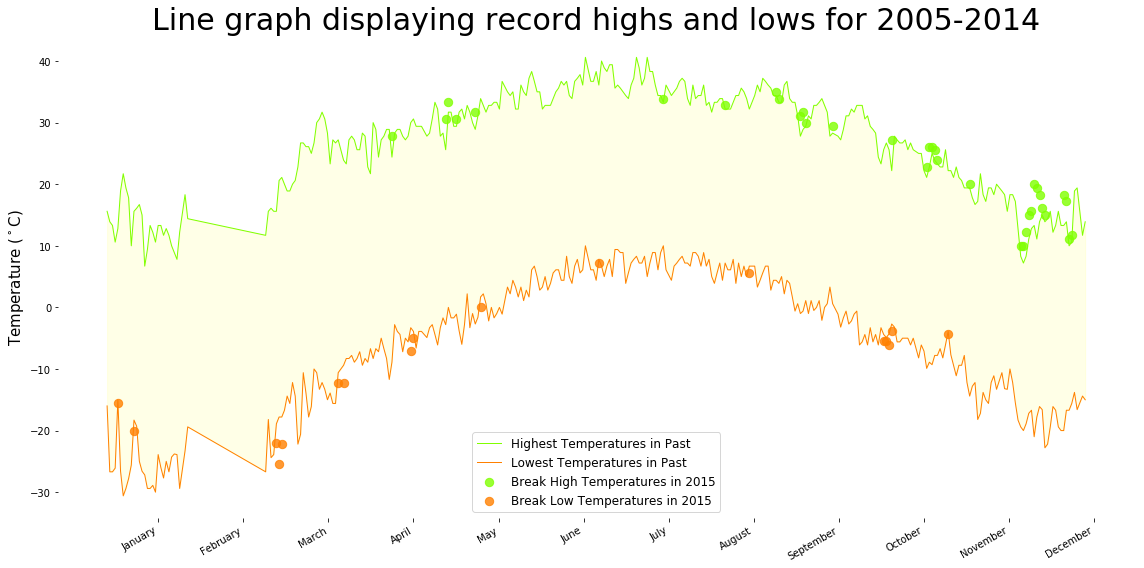

In [449]:
plt.clf()
plt.figure(figsize=(16, 8))

#########
plt.plot(
    'Day', 'max_temp_2004_2014', 
    data = data, 
    markersize=2, 
    linewidth=1, 
    c='#80ff00', 
    alpha=1, 
    label='Highest Temperatures in Past'
)

plt.plot(
    'Day', 'min_temp_2004_2014', 
    data = data, 
    markersize=2, 
    linewidth=1, 
    c='#ff8000', 
    alpha=1, 
    label='Lowest Temperatures in Past'
)
#########
plt.fill_between(
    temp['Day'], 
    temp['max_temp_2004_2014'], 
    temp['min_temp_2004_2014'], 
    interpolate=True, 
    alpha=0.2,
    color = '#ffff89'
)
#########
plt.scatter(
    'Day', 
    'max_temp_2015', 
    data = data, 
    c='#80ff00', 
    s=70, 
    label='Break High Temperatures in 2015', 
    alpha=0.8
)
plt.scatter(
    'Day', 
    'min_temp_2015', 
    data = data, 
    c='#ff8000', 
    s=70, 
    label='Break Low Temperatures in 2015', 
    alpha=0.8
)
########
plt.title('Line graph displaying record highs and lows for 2005-2014', fontsize=30)
plt.ylabel('Temperature ($^\circ$C)', fontsize=15)

for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
x = np.linspace(20, 400, 13)[:-1]    
plt.xticks(
    x, 
    months
)
plt.gcf().autofmt_xdate();
plt.tight_layout();
plt.legend(loc=8, fontsize=12);

# In case it is required to save, capture the figure object
fig1 = plt.gcf();
plt.show();

In [450]:
fig1.savefig('weather_pattern2015.png', dpi=300)